In [ ]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd 
import awkward as ak 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [ ]:
input_folder = "/eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron/ntuples/"

In [ ]:
f = uproot.open(file)
t =  f["ticlNtuplizer/tracksters"]
calo = f["ticlNtuplizer/simtrackstersCP"]
ass = f["ticlNtuplizer/associations"]

In [ ]:
ass.keys()

In [ ]:
calo.keys()

In [194]:
t.keys()

['event',
 'NClusters',
 'NTracksters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'trackster_barycenter_eta',
 'trackster_barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity',
 'layer_cluster_seed']

In [ ]:
import glob

files = glob.glob(f"{input_folder}/ntuples_13723002_*.root")

calos = [ ]
tracksters = [ ]
associations = [ ]

i = 0
N = 100
for file in files:
    if i >= N: break
    i+=1
    try:
        print('.', end="")
        f = uproot.open(file)
        t =  f["ticlNtuplizer/tracksters"]
        calo = f["ticlNtuplizer/simtrackstersCP"]
        ass = f["ticlNtuplizer/associations"]
        calos.append(calo.arrays(["stsCP_trackster_barycenter_eta","stsCP_trackster_barycenter_phi",
                                  "stsCP_barycenter_x","stsCP_barycenter_y","stsCP_barycenter_z"]))
        tracksters.append(t.arrays(["raw_energy","trackster_barycenter_eta","trackster_barycenter_phi",
                                    "barycenter_x","barycenter_y","barycenter_z","id_probabilities",
                                    "EV1", "EV2", "EV3", "eVector0_x", "eVector0_y","eVector0_z", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"]))
        associations.append(ass.arrays([ "tsCLUE3D_recoToSim_CP", "tsCLUE3D_recoToSim_CP_score"]))
    except:
        print("error ", file)
        
df_calo = ak.concatenate(calos)
df_track = ak.concatenate(tracksters)
df_ass = ak.concatenate(associations)

.......................................................................................

In [188]:
ak.num(df_track.trackster_barycenter_eta)

<Array [11, 4, 3, 5, 8, 11, ... 6, 10, 9, 5, 5] type='10000 * int64'>

In [189]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='10000 * int64'>

In [ ]:
df_ass[0].tolist()

In [ ]:
t.keys()

In [ ]:
df_calo.stsCP_trackster_barycenter_eta

In [ ]:
f, ax = plt.subplots(1,2, figsize=(16,8), dpi=150)

zmaskP = df_calo.stsCP_trackster_barycenter_eta > 0 
zmaskM = df_calo.stsCP_trackster_barycenter_eta < 0 

ax[0].hist2d(np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((1.5,3.5),(-3.14,3.14)), cmin=1)
ax[0].set_xlabel("eta")
ax[0].set_ylabel("phi")

ax[1].hist2d(np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((-3.5,-1.5),(-3.14,3.14)), cmin=1)
ax[1].set_xlabel("eta")
ax[1].set_ylabel("phi")


In [ ]:
def in_window_nonumba(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.1
    dphi = 0.2
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

In [ ]:
import numba

@numba.njit
def in_window(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.1
    dphi = 0.2
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

In [ ]:
pairs = ak.argcartesian([df_calo.stsCP_trackster_barycenter_eta, df_track.trackster_barycenter_eta], axis=1)

In [ ]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

In [ ]:
ak.num(df_track.trackster_barycenter_eta)

In [ ]:
calo_idx, track_idx = ak.unzip(pairs)

In [ ]:
df_calo.eta = df_calo.stsCP_trackster_barycenter_eta
df_calo.phi = df_calo.stsCP_trackster_barycenter_phi
df_calo.z = df_calo.stsCP_barycenter_z

df_track.eta = df_track.trackster_barycenter_eta
df_track.phi = df_track.trackster_barycenter_phi
df_track.z = df_track.barycenter_z

In [ ]:
all_calo_eta = df_calo.stsCP_trackster_barycenter_eta[calo_idx]
all_calo_phi = df_calo.stsCP_trackster_barycenter_phi[calo_idx]
all_calo_z = df_calo.stsCP_barycenter_z[calo_idx]

all_track_eta = df_track.trackster_barycenter_eta[track_idx]
all_track_phi = df_track.trackster_barycenter_phi[track_idx]
all_track_z = df_track.barycenter_z[track_idx]

In [ ]:
%%timeit
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [ ]:
%%timeit
out = in_window_nonumba(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [ ]:
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [ ]:
goodpairs = pairs[out]

Now we have the pairs of caloparticle-trackers that are close in a window

In [ ]:
calo_idx_inwindow, track_idx_inwindow = ak.unzip(goodpairs)

In [ ]:
import numba
@numba.njit
def calo_match_mask(tcks_indices, indices_to_match,builder):
    for tr_ind, index_to_match in zip(tcks_indices, indices_to_match):
        builder.begin_list()
        #Looping other all the calolist for each trackers
        for trInd in range(len(tr_ind)):    
            calo_indices_for_this_track = tr_ind[trInd]
            #print(calo_indices_for_this_track)
            builder.begin_list()
            for i in range(len(calo_indices_for_this_track)):
                # checking if the index is the one to keep
                if i == index_to_match[trInd]:
                    builder.append(True)
                else:
                    builder.append(False)
            builder.end_list()
        builder.end_list()
    return builder

In [ ]:
masked_score  = ak.mask(df_ass.tsCLUE3D_recoToSim_CP_score, df_ass.tsCLUE3D_recoToSim_CP_score<0.1)

In [ ]:
armin = ak.argmin(masked_score, axis=2)
mask_for_calomatching_trackers = calo_match_mask(df_ass.tsCLUE3D_recoToSim_CP, armin, ak.ArrayBuilder())
trackers_to_calo = ak.flatten(df_ass.tsCLUE3D_recoToSim_CP[mask_for_calomatching_trackers], axis=-1)

Now we have the caloindex of each tracker in `trackers_to_calo` and the trackers close to each calo in the `calo_idx_inwindow` and `track_idx_inwindow` arrays

In [ ]:
trackers_to_calo.tolist()

In [ ]:
goodpairs.tolist()

We now can get the indices of all the trackers close a calo 0

In [ ]:
track_idx_inwindow[calo_idx_inwindow == 0].tolist()

In [ ]:
track_idx_inwindow[calo_idx_inwindow == 1].tolist()

Or get the **true** caloparticle matched to each trackers that is in the windo of caloparticle 0

In [ ]:
(trackers_to_calo[   track_idx_inwindow[calo_idx_inwindow == 0] ] == 0).tolist()

### Extracting info

In [ ]:
df_track.type

In [ ]:
norm_PCAVect = (df_track.eVector0_x **2 + df_track.eVector0_y**2  + df_track.eVector0_z**2)**0.5
norm_baryVect = (df_track.barycenter_x **2 + df_track.barycenter_y**2  + df_track.barycenter_z**2)**0.5

In [142]:
norm_vect

<Array [[1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1]] type='1000 * var * float32'>

In [ ]:
prod_scalar = (df_track.barycenter_x * df_track.eVector0_x + df_track.barycenter_y * df_track.eVector0_y + \
                        df_track.barycenter_z * df_track.eVector0_z) /(norm_PCAVect*norm_baryVect)

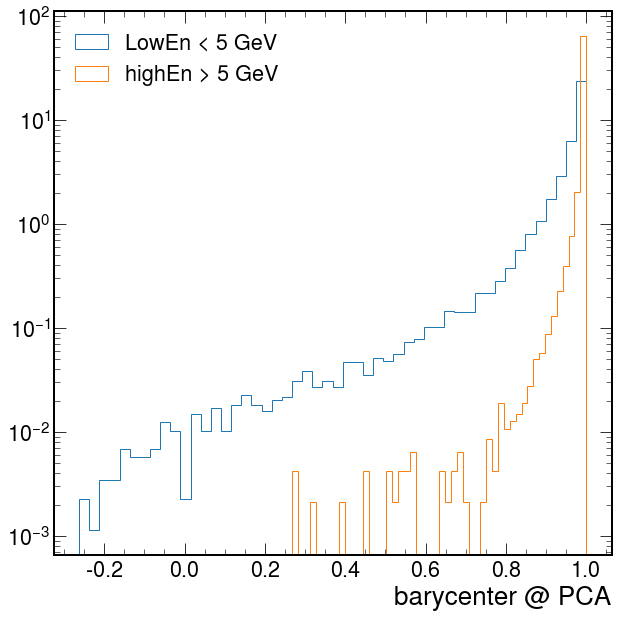

In [193]:
plt.hist(ak.flatten(prod_scalar[df_track.raw_energy< 5] ), bins=50, density=True, histtype="step", label="LowEn < 5 GeV")
plt.hist(ak.flatten(prod_scalar[df_track.raw_energy> 5] ), bins=50, density=True, histtype="step", label="highEn > 5 GeV")
plt.legend()
plt.xlabel("barycenter @ PCA")
plt.yscale("log")